In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("FinalBalancedDataset.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
data.head(5)

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [5]:
data = data.drop("Unnamed: 0", axis=1)

In [6]:
data.head(5)

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
data['Toxicity'].value_counts()

Toxicity
0    32592
1    24153
Name: count, dtype: int64

## Text pre-processing

In [8]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [9]:
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
import re

In [11]:
def prepare_text(text):
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = ' '.join(text)
    text = word_tokenize(text)
    text = pos_tag(text)
    lemma = []
    for i in text: lemma.append(wordnet_lemmatizer.lemmatize(i[0], pos = get_wordnet_pos(i[1])))
    lemma = ' '.join(lemma)
    return lemma

In [12]:
data['clean_tweets'] = data['tweet'].apply(lambda x: prepare_text(x))

In [13]:
data.head(5)

,Toxicity,tweet,clean_tweets
0,0,@user when a father is dysfunctional and is s...,user when a father be dysfunctional and be so ...
1,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i ca n't use ...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,0,factsguide: society now #motivation,factsguide society now motivation


## Tf-idf for features

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [15]:
corpus = data['clean_tweets'].values.astype('U')

In [16]:
stopwords = set(nltk_stopwords.words('english'))

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
tf_idf = count_tf_idf.fit_transform(corpus)

In [18]:
import pickle

In [19]:
pickle.dump(count_tf_idf, open("tf_idf.pkt", "wb"))

In [20]:
tf_idf_train, tf_idf_test, target_train, target_test = train_test_split(
    tf_idf, data['Toxicity'], test_size = 0.7, random_state= 42, shuffle=True
)

## Create a Binary Classification Model

In [21]:
model_bayes = MultinomialNB()

In [22]:
model_bayes = model_bayes.fit(tf_idf_train, target_train)

In [23]:
y_pred_proba = model_bayes.predict_proba(tf_idf_test)[::, 1]

In [24]:
y_pred_proba

array([0.90788672, 0.31110166, 0.82183099, ..., 0.30042349, 0.76724951,
       0.04184846])

In [25]:
fpr, tpr, _ = roc_curve(target_test, y_pred_proba)

In [26]:
final_roc_auc = roc_auc_score(target_test, y_pred_proba)

In [27]:
final_roc_auc

0.967818753567437

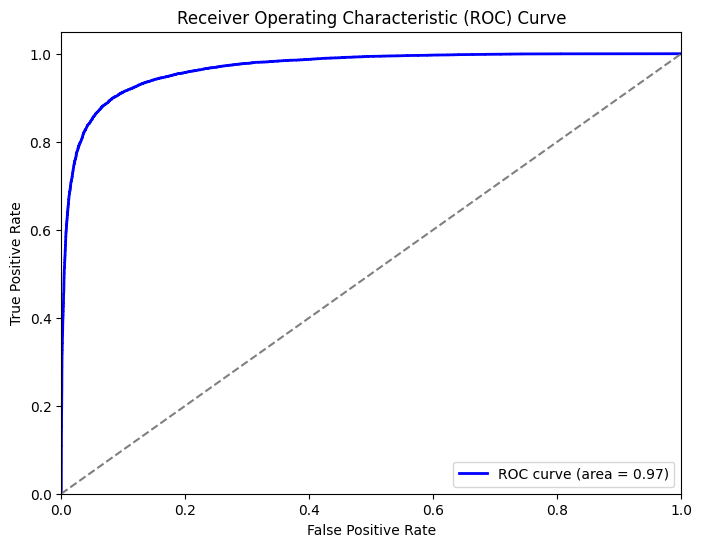

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

# Convert probabilities to class labels (assuming a threshold of 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)
f1 = f1_score(target_test, y_pred)
accuracy = accuracy_score(target_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.93
Recall: 0.85
F1 Score: 0.89
Accuracy: 0.91


In [30]:
test_text = "You are Ugly!"
test_tfidf = count_tf_idf.transform([test_text])
display(model_bayes.predict_proba(test_tfidf))
display(model_bayes.predict(test_tfidf))

array([[0.15300093, 0.84699907]])

array([1])

## Save the model

In [31]:
pickle.dump(model_bayes, open("toxicity_model.pkt", "wb"))